In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, minmax_scale
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import sys 
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.utils import np_utils
import tensorflow as tf
#from keras.regularizers import L1L2
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.utils import shuffle
#from keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from featurewiz import featurewiz
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.feature_selection import mutual_info_classif
np.random.seed(19680801)

Imported version = 0.1.70.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


In this file, I am keeping all the finalized codes for outcites. I have the unified model and best f1 score codes for outcites. At the beginning, we will clean the main training file and remove any null valued columns. As it is already done, we wont do it again.

In [2]:
##preprocess the main training file(training_step1.py)
data = pd.read_csv("gold_control_datapoints_prized_samp_fda.csv")
data = data.sort_values(by=['cluster'])
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
data = shuffle(data)
print(len(data))
data.dropna(axis=0, inplace= True)
print(len(data))
data['class'] = data['class'].astype(int)
#print(data.dtypes)
#data = data[data.year >= 1984]
data = data.sort_values(by=['year'])
data.to_csv("data_84.csv", index = False)
print(len(data))

296
292
292


length of training file  292
pct_is_new                   float64
pct_is_newish                float64
n_biggest_anc                  int64
pct_of_biggest_anc           float64
n_secbiggest_anc               int64
pct_of_secbiggest_anc_new    float64
pct_top_5_anc                float64
wrcr                         float64
rcr_mid                      float64
rcr_hi                       float64
human                        float64
animal                       float64
molecular_cellular           float64
is_clinical                  float64
is_research_article          float64
cited_by_clin                float64
dtype: object
top 10
n_secbiggest_anc             0.000813
n_biggest_anc                0.006336
pct_of_secbiggest_anc_new    0.037676
wrcr                         0.048941
rcr_mid                      0.071668
molecular_cellular           0.076117
rcr_hi                       0.077502
cited_by_clin                0.086545
animal                       0.100404
pct_top_5_anc   

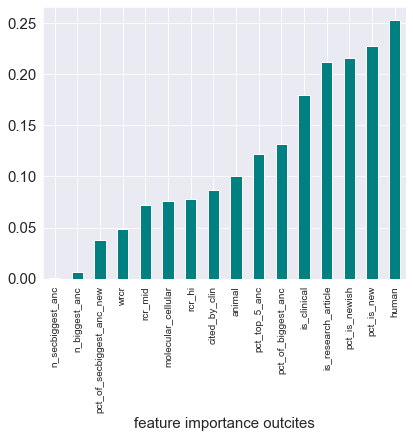

cv score by sklearn  0.8325062021323999


In [14]:
##Best f1 score for logistic regression on outcites edge type
##Logistic Regression
##best f1 score logistic model

def train(x_train):
    
    print("length of training file ",len(x_train))
  
    y_train = x_train['class']
    
    x_train = x_train.drop(['class','cluster','year','n','pct_dusted_ccn','pct_dusted_rmcl','pct_of_secbiggest_anc',
                           'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                           'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','rage','nih','n_clusts_90_anc'
                           ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                           ], axis = 1)
    
    print(x_train.dtypes)
    
    sns.set_style('darkgrid')
    sns.set_palette('Set2')
    fig = plt.figure(figsize=(6.5,5))
    importance = mutual_info_classif(x_train,y_train)
    feat_imp = pd.Series(importance,x_train.columns[0:len(x_train.columns)])
    
    feat_imp = feat_imp.sort_values(ascending=True)
    feat_imp = feat_imp.tail(18)
    print("top 10")
    print(feat_imp)
    feat_imp.plot(kind = 'bar',color = 'teal')
    plt.xlabel("feature importance outcites",fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()
    fig.savefig("best_f1_outcite.png",bbox_inches ="tight",dpi = 400)
    
    
    x_train =  StandardScaler().fit_transform(x_train) 

    y_train = np.array(y_train)
    model = LogisticRegression(random_state=0, C = 10).fit(x_train,y_train) ##logistioc
    #crossvalidation2(x_train, y_train)
    #print(model.intercept_, model.coef_, model.score(x_train, y_train))
    scores = cross_val_score(model, x_train, y_train, cv=5,scoring = "f1")
    print("cv score by sklearn ",scores.mean())
    

x_train = pd.read_csv("data_84.csv")
train(x_train)

In [11]:
##logistic regression: unififed model for all

def recall(pred,th, yr):
    data = pd.read_csv("data_84.csv")
    data = data[data['year'] == yr]
    data = data[data['n'] > 100]

    tot = 0
    res = pd.merge(data,pred,on='cluster', how = 'inner')
    tp,tn,fp, fn = 0,0,0,0
    for ind in res.index:
        if res['class'][ind] == 1 and res['pred_log'][ind] >= th:
            tp += 1
        elif res['class'][ind] == 0 and res['pred_log'][ind] < th:
            tn += 1
        elif res['class'][ind] == 0 and res['pred_log'][ind] >= th:
            fp += 1
        elif res['class'][ind] == 1 and res['pred_log'][ind] < th:
            fn += 1
    pred = pred[pred['pred_log'] >= th]
    print("total positive ", len(pred))
    print("tp tn fp fn",tp," ",tn," ",fp," ",fn)
    total_pos = len(res[res['class'] == 1])
    print("year ",yr,"positive ",total_pos)
    
    
    #return total_pos,tp,len(pred[pred['pred_log'] >= th]) - tp
    return total_pos,tp,len(pred) - tp

CV = 0
def train(x_train):
    
    
  
    y_train = x_train['class']
    
    x_train = x_train.drop(['class','cluster','year','n','pct_dusted_ccn','pct_dusted_rmcl',
                           'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                           'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                           ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                           ], axis = 1)
    
    x_train[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_train[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    
    
    
    y_train = np.array(y_train)
 
    model = LogisticRegression(random_state=0, C = 1).fit(x_train,y_train) ##logistioc
    
    '''crossvalidation2(x_train, y_train)
    print(model.intercept_, model.coef_, model.score(x_train, y_train))'''
    scores = cross_val_score(model, x_train, y_train, cv=10,scoring = "f1")
    print("cv score ", scores.mean())
    return model,scores.mean()
    
tot,tp,total_fp = 0,0,0
yr = 1978

while yr <= 2020:
    
    x_train = pd.read_csv("data_84.csv")
    x_test = pd.read_csv("~/Documents/PhD/project_nobel/boty/boty_outcites/features_prediction_"+str(yr)+".csv")
    print("actual len ",len(x_test))
    x_test = x_test.dropna(axis=0)
    
    x_test = x_test[x_test['n'] > 100]
    
    x_test = x_test[x_test['rcr_hi'] >= 2.00]
    x_test = x_test[x_test['cited_by_clin'] >= 0.080]
    x_test = x_test[x_test['animal'] >= 0.01]

    x_test = x_test[x_test['molecular_cellular'] >= 0.020] ##this one, with C = 1
    x_test = x_test[x_test['human'] >= 0.20]
    print("len of xtest ",len(x_test))
       
    copy_test = x_test.copy()
    #print(x_test.tail(10))
    
    #x_test = x_test[x_test['is_research_article'] > 0.75]
    x_test = x_test.drop(['prediction','cluster','year','n',
                               'pct_in_secbiggest_anc','rcr_low','secbiggest_anc',
                               'pct_of_biggest_anc_newish','pct_of_biggest_anc_new','n_clusts_90_anc'
                               ,'pct_in_biggest_anc','biggest_anc','pct_of_secbiggest_anc_newish'
                               ], axis = 1)
    print("magic%%%%%%%")
    print(x_test.head(10))
    x_test[['pct_of_biggest_anc','pct_is_newish','wrcr']] = minmax_scale(x_test[[
    'pct_of_biggest_anc','pct_is_newish','wrcr']])
    
    print(x_test.head(10))
    
    print("hdhdhd before ",len(x_train))
    x_train = x_train[x_train['year'] != yr]
    x_train = x_train[x_train['n'] > 100]

    
    #x_train = x_train[x_train['is_research_article'] > 0.75]
    print('len of xtrain ', len(x_train))
    print("year  ",yr)
    print(x_train['year'].unique())

    model,cv = train(x_train)
    CV += cv
    pred = model.predict(x_test)
    print(pred.shape)
    #print(np.sum(pred))
    #print("no of positive ",np.count_nonzero(pred == 1))
    

    
    predy = model.predict_proba(x_test)
    pred_test = []
    for i in range(predy.shape[0]):
        pred_test.append(predy[i][1])
        '''if predy[i][0] >= predy[i][1]:
            #pred_test.append(0.00)
            pred_test.append(predy[i][1])
        else:
            pred_test.append(predy[i][1])'''
    
    predy = pd.DataFrame(predy, columns = ['col_0','col_1'])
    #print("fhfhfh fhhfh &&&& ",len(predy[predy['col_1'] >= 0.50]))
    predy = predy[predy['col_1'] >= 0.75]
    #print("len of df ", len(df))
    print("len of predy ", len(predy))
    
    
    
    
    copy_test['pred_log'] = pred_test
    #copy_test['pred_log'].hist()
    #plt.show()
    
    #copy_test.to_csv("prediction_unified_"+str(yr)+".csv", index = False)
    print("$$$ ",len(copy_test)," ",len(copy_test[copy_test['pred_log'] >= 0.75]))
    a, b,c = recall(copy_test,0.75, yr)
    tot += a
    tp += b
    total_fp += c
    yr += 1
print("total pos ",tot," true pos ", tp," total false pos ",total_fp/43," mean cv ",CV/43)

actual len  8714
len of xtest  307
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
2     0.188939       0.207253         5375.0            0.907163   
3     0.057512       0.070415         5389.0            0.971423   
4     0.068025       0.073405         5187.0            0.948332   
7     0.054678       0.060146         4907.0            0.968005   
8     0.247510       0.287552         4257.0            0.950669   
18    0.133837       0.141394         3946.0            0.930563   
20    0.066895       0.081843         4096.0            0.942627   
22    0.157171       0.158153         3977.0            0.918280   
23    0.007628       0.010335         4083.0            0.972814   
26    0.210175       0.219066         3900.0            0.914615   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
2              486.0               0.018519                   0.518519   
3             3977.0               0.001257            

cv score  0.7688639967950313
(332,)
len of predy  110
$$$  332   110
total positive  110
tp tn fp fn 0   0   0   0
year  1979 positive  0
actual len  9441
len of xtest  345
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
2     0.133696       0.152143         5712.0            0.909139   
3     0.160458       0.192693         5291.0            0.949348   
8     0.041235       0.045172         4862.0            0.959687   
9     0.039540       0.042678         5357.0            0.842076   
10    0.049674       0.057462         4989.0            0.893365   
11    0.141981       0.141543         4277.0            0.963058   
15    0.103700       0.116774         4347.0            0.968714   
16    0.177674       0.185679         4334.0            0.923396   
17    0.179590       0.183155         4186.0            0.951744   
21    0.164305       0.171846         4082.0            0.967908   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_an

cv score  0.7524690539345712
(416,)
len of predy  176
$$$  416   176
total positive  176
tp tn fp fn 0   0   0   1
year  1982 positive  1
actual len  10637
len of xtest  444
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
5     0.056826       0.068771         5722.0            0.977281   
6     0.164019       0.183830         5651.0            0.884976   
7     0.134222       0.150742         5124.0            0.954528   
9     0.097172       0.110457         5785.0            0.838894   
10    0.105223       0.123713         5098.0            0.946057   
11    0.129026       0.138420         5042.0            0.950417   
14    0.177252       0.185069         4784.0            0.940635   
15    0.244037       0.247191         4604.0            0.942007   
17    0.150890       0.158778         4666.0            0.944706   
18    0.138315       0.151681         4849.0            0.916271   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_a

cv score  0.7688639967950313
(530,)
len of predy  155
$$$  530   155
total positive  155
tp tn fp fn 0   0   0   0
year  1985 positive  0
actual len  12054
len of xtest  565
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
1     0.186927       0.181494         6061.0            0.942419   
5     0.099468       0.110945         6001.0            0.931678   
6     0.021000       0.026500         5988.0            0.982966   
7     0.132333       0.153333         5767.0            0.953529   
10    0.083433       0.092189         5669.0            0.973011   
11    0.071966       0.087725         5645.0            0.963153   
13    0.126742       0.144302         5040.0            0.959921   
14    0.057696       0.073797         5364.0            0.923192   
19    0.065916       0.086817         4958.0            0.957846   
20    0.103197       0.115743         5909.0            0.760535   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_a

len of xtest  663
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.139610       0.161632         6772.0            0.951122   
4     0.091215       0.110258         6086.0            0.963359   
5     0.047952       0.069098         6020.0            0.957807   
6     0.004666       0.009665         6001.0            0.988169   
7     0.046387       0.060237         5881.0            0.983846   
9     0.467148       0.418081         4516.0            0.932905   
10    0.042665       0.055074         5819.0            0.975941   
14    0.100286       0.109208         5495.0            0.947589   
15    0.088559       0.111845         5214.0            0.978328   
18    0.060294       0.080328         5124.0            0.980874   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
0              234.0               0.128205                   0.653846   
4               72.0               0.208333                   0.555556  

len of xtrain  275
year   1989
[1982 1987 1988 1990 1993 1996 1997 1998 1999 2000 2002 2003 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
cv score  0.7688639967950313
(699,)
len of predy  183
$$$  699   183
total positive  183
tp tn fp fn 0   0   0   0
year  1989 positive  0
actual len  14399
len of xtest  771
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.104347       0.111809         7386.0            0.956946   
1     0.318115       0.339466         6589.0            0.907877   
5     0.059045       0.078235         6097.0            0.957684   
6     0.027972       0.032468         6001.0            0.974671   
7     0.002833       0.004333         6001.0            0.987502   
8     0.030167       0.032667         5995.0            0.972477   
9     0.030380       0.035642         6000.0            0.949000   
15    0.060052       0.072585         5589.0            0.973877   
17    0.055351       0.0665

actual len  15614
len of xtest  860
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.080157       0.094720           7843            0.952824   
2     0.241914       0.257953           7235            0.883207   
3     0.357539       0.352438           6000            0.883833   
4     0.014662       0.022072           6437            0.962560   
7     0.027240       0.038398           6109            0.971845   
11    0.017664       0.022163           6000            0.981500   
12    0.001667       0.001333           6001            0.989335   
15    0.014910       0.019880           5978            0.956842   
16    0.060106       0.079341           5755            0.966638   
19    0.026229       0.037867           5786            0.975112   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
0               1033               0.022265                   0.426912   
2                235               0.136170           

cv score  0.7588897309586965
(903,)
len of predy  322
$$$  903   322
total positive  322
tp tn fp fn 1   1   0   0
year  1993 positive  1
actual len  16911
len of xtest  994
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.176602       0.207519         7946.0            0.917694   
1     0.061204       0.068823         8000.0            0.962000   
2     0.236265       0.260333         7355.0            0.921550   
8     0.009690       0.010008         6303.0            0.985721   
9     0.093144       0.120472         6111.0            0.954017   
11    0.015029       0.020974         6102.0            0.964602   
12    0.115007       0.134286         5959.0            0.942272   
14    0.001338       0.001338         5965.0            0.995809   
15    0.009382       0.013403         5973.0            0.984765   
16    0.040375       0.047914         5938.0            0.971539   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_a

actual len  18277
len of xtest  1130
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
1     0.116592       0.144164         7883.0            0.951541   
2     0.046619       0.053118         8046.0            0.953890   
3     0.140364       0.175262         7629.0            0.921484   
11    0.003825       0.005738         6294.0            0.983794   
12    0.047557       0.061307         6168.0            0.962549   
13    0.184279       0.186073         5891.0            0.922594   
15    0.074257       0.086249         6114.0            0.951259   
16    0.110690       0.132959         6001.0            0.933344   
17    0.010328       0.009662         6001.0            0.982503   
19    0.189000       0.196500         5589.0            0.950259   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
1             1541.0               0.009085                   0.386113   
2             4000.0               0.004500          

actual len  19596
len of xtest  1250
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
2     0.071625       0.093625         7768.0            0.960221   
3     0.032920       0.042308         7889.0            0.984028   
4     0.072373       0.094505         7868.0            0.943950   
5     0.281707       0.306270         7159.0            0.908926   
8     0.166500       0.169351         6550.0            0.959542   
12    0.124849       0.143245         6293.0            0.968378   
14    0.143579       0.163007         6074.0            0.952585   
15    0.286234       0.294927         5818.0            0.930904   
16    0.029267       0.035947         6223.0            0.977021   
17    0.002092       0.002414         6281.0            0.980895   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
2             2025.0               0.015802                   0.296790   
3             1895.0               0.010554          

actual len  21025
len of xtest  1357
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
2     0.171949       0.199150         8061.0            0.917752   
3     0.030125       0.046000         7985.0            0.974703   
5     0.014760       0.018705         7989.0            0.967956   
6     0.206839       0.218710         7001.0            0.972575   
7     0.032538       0.044076         7839.0            0.956755   
8     0.238967       0.253095         6562.0            0.973636   
9     0.091618       0.111757         6883.0            0.959175   
10    0.251071       0.226663         6393.0            0.909119   
15    0.107154       0.122461         6352.0            0.959068   
18    0.171320       0.163387         6060.0            0.937954   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
2             9660.0               0.001967                   0.374224   
3             1684.0               0.004751          

actual len  22884
len of xtest  1439
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
2     0.160570       0.187098         8003.0            0.975134   
4     0.239055       0.244279         7651.0            0.889165   
5     0.161000       0.172125         8000.0            0.884875   
6     0.116455       0.145915         8127.0            0.882614   
7     0.210380       0.242882         7340.0            0.933106   
8     0.012349       0.018271         7986.0            0.979715   
9     0.149587       0.160367         7000.0            0.946143   
10    0.073275       0.081268         7270.0            0.974415   
11    0.001398       0.002796         7397.0            0.951467   
12    0.093030       0.104337         6760.0            0.964349   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
2               91.0               0.076923                   0.450549   
4             1029.0               0.013605          

cv score  0.7734974599824432
(1468,)
len of predy  351
$$$  1468   351
total positive  351
tp tn fp fn 0   0   1   1
year  2003 positive  1
actual len  24651
len of xtest  1483
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
1     0.117501       0.136359         9109.0            0.980239   
4     0.148359       0.179143         8340.0            0.952518   
5     0.115112       0.131490         8234.0            0.971581   
6     0.216686       0.225147         7708.0            0.937727   
7     0.126058       0.145274         8003.0            0.945146   
8     0.066551       0.081738         8050.0            0.955528   
9     0.002161       0.002924         7906.0            0.979130   
10    0.054685       0.065392         7688.0            0.975156   
11    0.086911       0.093647         7389.0            0.963595   
13    0.095303       0.095714         7012.0            0.973902   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbigges

cv score  0.7556475867682765
(1500,)
len of predy  315
$$$  1500   315
total positive  315
tp tn fp fn 1   1   0   2
year  2005 positive  3
actual len  26791
len of xtest  1544
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.084131       0.101817        10000.0            0.973300   
2     0.110351       0.133147         9252.0            0.968439   
3     0.150465       0.175382         8932.0            0.940215   
5     0.087340       0.101283         8746.0            0.968557   
7     0.128096       0.136509         8459.0            0.879537   
8     0.132533       0.135627         7780.0            0.947172   
9     0.043364       0.050487         7959.0            0.966956   
11    0.093655       0.090990         7644.0            0.970304   
12    0.061318       0.076392         7790.0            0.959949   
13    0.143516       0.151709         7384.0            0.952736   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbigges

cv score  0.779373742724132
(1588,)
len of predy  485
$$$  1588   485
total positive  485
tp tn fp fn 2   0   1   0
year  2007 positive  2
actual len  28867
len of xtest  1624
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.052671       0.067998        10575.0            0.985626   
1     0.102210       0.121885         9620.0            0.959771   
4     0.056735       0.072072         9140.0            0.981729   
5     0.077595       0.090527        10000.0            0.835000   
6     0.094496       0.123152         8834.0            0.912384   
8     0.109689       0.114302         8328.0            0.959054   
9     0.356757       0.347591         7431.0            0.900821   
11    0.173570       0.193321         8001.0            0.926009   
13    0.095635       0.092613         8041.0            0.961572   
14    0.104948       0.121319         8035.0            0.949969   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest

cv score  0.7491529790660225
(1672,)
len of predy  448
$$$  1672   448
total positive  448
tp tn fp fn 11   3   1   0
year  2009 positive  11
actual len  31270
len of xtest  1717
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.038392       0.041841        10963.0            0.978199   
1     0.166265       0.161951         9058.0            0.947229   
2     0.055408       0.067223         9903.0            0.942947   
5     0.061063       0.073896         9068.0            0.971989   
7     0.103201       0.111883         9001.0            0.951117   
10    0.059501       0.065928         9122.0            0.930059   
11    0.286634       0.288188         9280.0            0.771875   
13    0.022462       0.028527         9115.0            0.955239   
14    0.105785       0.113949         8165.0            0.975995   
16    0.075232       0.084859         8279.0            0.960502   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbigg

cv score  0.7609714922758402
(1777,)
len of predy  385
$$$  1777   385
total positive  385
tp tn fp fn 10   4   2   4
year  2011 positive  14
actual len  33915
len of xtest  1832
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.016894       0.021164        10846.0            0.980546   
1     0.230941       0.239391         9906.0            0.930850   
2     0.130052       0.147586        10118.0            0.945839   
3     0.473876       0.415109         8608.0            0.866520   
6     0.127154       0.133199         9476.0            0.953672   
8     0.032811       0.036807         9681.0            0.949592   
9     0.087365       0.094126         9439.0            0.931772   
11    0.033145       0.046574         9375.0            0.964160   
13    0.094475       0.107476         9004.0            0.971679   
14    0.101200       0.101422         8668.0            0.962621   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbigg

cv score  0.7601651032625545
(1907,)
len of predy  513
$$$  1907   513
total positive  513
tp tn fp fn 13   3   1   2
year  2013 positive  15
actual len  37143
len of xtest  2019
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.353501       0.366231        13007.0            0.936188   
1     0.176461       0.202258        11794.0            0.925301   
2     0.096500       0.120299        11123.0            0.960352   
4     0.237033       0.227857         9334.0            0.932398   
5     0.084814       0.100217        10028.0            0.947946   
8     0.166700       0.175596         9179.0            0.952936   
9     0.011725       0.010808        10000.0            0.959300   
10    0.096758       0.102316         9405.0            0.960553   
11    0.077195       0.085622         9479.0            0.958540   
12    0.098817       0.098294         9322.0            0.958378   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbigg

cv score  0.7896149743327163
(2118,)
len of predy  698
$$$  2118   698
total positive  698
tp tn fp fn 3   0   2   1
year  2015 positive  4
actual len  40764
len of xtest  2200
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.205846       0.268634        16617.0            0.942890   
1     0.119233       0.141690        12694.0            0.952103   
2     0.235783       0.220667        11507.0            0.919180   
3     0.081987       0.095418        10912.0            0.968933   
5     0.165031       0.186828        10000.0            0.950600   
6     0.125131       0.139723        10115.0            0.946713   
7     0.208431       0.230243         9541.0            0.942459   
8     0.057582       0.068034        10217.0            0.951062   
9     0.073890       0.082155         9934.0            0.951278   
10    0.126287       0.135286         9553.0            0.965665   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbigges

cv score  0.7701939184697805
(2274,)
len of predy  674
$$$  2274   674
total positive  674
tp tn fp fn 2   1   0   1
year  2017 positive  3
actual len  44336
len of xtest  2341
magic%%%%%%%
    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.110152       0.155058        18152.0            0.799251   
1     0.235145       0.230559        13678.0            0.903275   
2     0.126927       0.141924        11297.0            0.966628   
3     0.063551       0.072629        11716.0            0.961762   
4     0.160034       0.182531        11127.0            0.953806   
5     0.078630       0.088137        11419.0            0.961205   
8     0.096485       0.108330        10248.0            0.958041   
9     0.059605       0.068715        10152.0            0.968184   
15    0.196168       0.199526         9415.0            0.938927   
18    0.032700       0.040700        10079.0            0.957535   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbigges

    pct_is_new  pct_is_newish  n_biggest_anc  pct_of_biggest_anc  \
0     0.086523       0.194791        16568.0            0.946613   
1     0.239118       0.364780        14608.0            0.913147   
2     0.114220       0.201452        11936.0            0.939559   
3     0.127508       0.248145        11735.0            0.946112   
4     0.052829       0.097498        11896.0            0.961056   
8     0.076117       0.138387        11675.0            0.884300   
9     0.192150       0.300186        10124.0            0.949990   
10    0.090901       0.158331        10468.0            0.965780   
12    0.174215       0.270108         9970.0            0.944802   
13    0.131599       0.219015         9200.0            0.956714   

    n_secbiggest_anc  pct_of_secbiggest_anc  pct_of_secbiggest_anc_new  \
0             5180.0               0.008494                   0.252124   
1             9975.0               0.001404                   0.136441   
2              356.0         